# Hermite kernel demos
In this notebook, we construct Hermite activation functions whose NTKs mimic desired target kernels, reproducing Figure 1 of the paper.

## Imports and installs

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

if os.path.isdir('/content/eigenlearning'):
  !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

In [ ]:
import cvxopt

import jax
import jax.random as random
import jax.numpy as np

import matplotlib.pyplot as plt

import neural_tangents as nt

import numpy as base_np

from scipy.special import factorial, factorial2

import time

import utils, measures

In [ ]:
key = jax.random.PRNGKey(17)

## Helpers

In [ ]:
def psd_poly_fit(xs, fs, deg=5, endpt_wt=.1):

  n_to_add = round(((endpt_wt) * len(xs)) / (1 - endpt_wt))
  xs, fs = np.concatenate([xs[:1]]*n_to_add + [xs]), np.concatenate([fs[:1]]*n_to_add + [fs])

  Q = base_np.zeros((deg+1, deg+1))
  p = base_np.zeros((deg+1,))
  G = -1*base_np.eye(deg+1)
  h = 0*p

  for i in range(deg + 1):
    for j in range(deg + 1):
      Q[i][j] = 2*(xs**(i+j)).sum()
  for i in range(deg + 1):
    p[i] = -2*((xs**i)*fs).sum()
  
  Q = (10**3)*cvxopt.matrix(Q)
  p = (10**3)*cvxopt.matrix(p)
  G = cvxopt.matrix(G)
  h = cvxopt.matrix(h)
  
  cvxopt.solvers.options['show_progress'] = False
  sol = cvxopt.solvers.qp(Q, p, G, h)

  return base_np.array(sol['x']).flatten()

In [ ]:
def poly_coeffs_to_lambda_fn_string(c_alpha):
  output = "lambda z: "
  for i in range(len(c_alpha)):
    coeff = c_alpha[i]
    if coeff != 0:
      output += str(coeff) + "*z**" + str(i) + " + "
  return(output[:-3])

In [ ]:
def fcut(x, a=3):
  return ('{:.'+str(a)+'f}').format(x)

In [ ]:
def unit_circle_samples(n, cosine_spaced=False):
  if cosine_spaced:
    cosines = np.linspace(1, -1, n)
    sines = (1 - cosines**2)**.5
    X = np.stack([cosines, sines]).T * 2**.5
    thetas = np.arccos(cosines)
  
  else:
    thetas = np.linspace(0, np.pi, n)
    cosines = np.cos(thetas)
    sines = np.sin(thetas)
    X = np.stack([cosines, sines]).T * 2**.5

  return X, thetas

In [ ]:
def kernel_curve(phi, width=2**14):
  if width == 'inf':
    net_fns = utils.get_net_fns(1, 1, n_hidden_layers=1, W_std=1, b_std=0, phi=phi)
    return(net_fns[2](X, X[:1], 'ntk')[:,0])

  net_fns = utils.get_net_fns(width, 1, n_hidden_layers=1, W_std=1, b_std=0, phi=phi)

  global key
  key, subkey = random.split(key)
  _, params = net_fns[0](subkey, (-1,2))
  kernel_fn = nt.empirical_kernel_fn(net_fns[1])
  return(kernel_fn(X, X[:1], 'ntk', params)[:,0])

In [ ]:
def H_matrix(deg):
  H = [[(-1)**((col - row)/2) / factorial2(col - row) / factorial(row) * factorial(col)**.5
        if (col >= row)*((col + row)%2 == 0)
        else 0
        for col in range(deg)]
        for row in range(deg)]
  return np.array(H)

In [ ]:
H_matrix(4)

DeviceArray([[ 1.        ,  0.        , -0.70710677,  0.        ],
             [ 0.        ,  1.        ,  0.        , -1.2247449 ],
             [ 0.        ,  0.        ,  0.70710677,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.4082483 ]],            dtype=float32)

## Define target kernels

In [ ]:
X, thetas = unit_circle_samples(100)
cs = X[:,0] / 2**.5

In [ ]:
target_names, K_targets = ['']*7, {}

In [ ]:
target_names[0] = '4HL ReLU (NNGP)'

_, _, kernel_fn = utils.get_net_fns(1, 1, n_hidden_layers=4, W_std=2**.5, b_std=.1, phi='relu')
K_targets[target_names[0]] = kernel_fn(X, X[:1], get='nngp')[:,0]

In [ ]:
target_names[1] = '4HL ReLU (NTK)'

_, _, kernel_fn = utils.get_net_fns(1, 1, n_hidden_layers=4, W_std=2**.5, b_std=.1, phi='relu')
K_targets[target_names[1]] = kernel_fn(X, X[:1], get='ntk')[:,0]

In [ ]:
target_names[2] = '4HL erf (NTK)'

_, _, kernel_fn = utils.get_net_fns(1, 1, n_hidden_layers=4, W_std=2**.5, b_std=.1, phi='erf')
K_targets[target_names[2]] = kernel_fn(X, X[:1], get='ntk')[:,0]

In [ ]:
target_names[3] = '$K(c) = c^3$'

K_targets[target_names[3]] = cs**3

In [ ]:
target_names[4] = '$K(c) = c^4 + c$'

K_targets[target_names[4]] = cs**4 + cs

In [ ]:
target_names[5] = '$K(c) = \sinh(2c)$'

K_targets[target_names[5]] = np.sinh(2 * cs)

In [ ]:
target_names[6] = '$K(c) = \cosh(2c)$'

K_targets[target_names[6]] = np.cosh(2 * cs)

## Find mimic kernels

In [ ]:
K_mimics, phis = {}, {}

In [ ]:
for i, name in enumerate(target_names):
  if i > 8:
    continue
  
  sign_flips = np.array([1,1,-1,-1,1,1])

  K_coeffs = psd_poly_fit(cs, K_targets[name])
  h_coeffs = sign_flips * (K_coeffs / np.arange(1, len(K_coeffs)+1))**.5

  phi_coeffs = H_matrix(len(K_coeffs)) @ h_coeffs
  phi = eval(poly_coeffs_to_lambda_fn_string(phi_coeffs))
  phis[name] = phi


  K_phis = [kernel_curve(phi, width=2**14) for _ in range(2**4)]
  K_phi = sum(K_phis) / 2**4
  K_mimics[name] = K_phi

  print(f'hermite poly coeffs: {h_coeffs}')
  print(f'\\phi_{"ABCDEFGH"[i]} &= ' + ' + '.join([f'{fcut(a)} \, h_{j}' for j, a in enumerate(h_coeffs) if np.abs(a) > .001]) + ' \\\\')
  print(f'phi coeffs: {phi_coeffs}')

/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3733: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f64687cdc20>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'
/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3742: UserWarning: Using JAX autodiff to compute the `fn` derivative for NTK. Beware of https://jax.readthedocs.io/en/latest/faq.html#gradients-contain-nan-where-using-where.
  'Using JAX autodiff to compute the `fn` derivative for NTK. Beware of '


\phi_A &= 0.837 \, h_0 + 0.271 \, h_1 + -0.151 \, h_2 + -0.050 \, h_3 + 0.101 \, h_4 + 0.084 \, h_5 \\


/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3733: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f64684b1b00>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'


\phi_B &= 1.230 \, h_0 + 0.639 \, h_1 + 0.539 \, h_4 + 0.426 \, h_5 \\


/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3733: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f64646b6320>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'


\phi_C &= 0.153 \, h_0 + 0.826 \, h_1 + -0.004 \, h_2 + -0.005 \, h_3 + 0.219 \, h_4 + 0.577 \, h_5 \\


/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3733: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f64687fcd40>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'


\phi_D &= 0.001 \, h_0 + 0.010 \, h_1 + -0.500 \, h_3 + 0.009 \, h_5 \\


/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3733: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f6464862a70>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'


\phi_E &= 0.707 \, h_1 + -0.004 \, h_2 + -0.003 \, h_3 + 0.447 \, h_4 \\


/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3733: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f64647cba70>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'


\phi_F &= 1.001 \, h_1 + -0.572 \, h_3 + 0.004 \, h_4 + 0.229 \, h_5 \\


/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:3733: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f6464286ef0>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'


\phi_G &= 1.002 \, h_0 + -0.805 \, h_2 + 0.404 \, h_4 + 0.011 \, h_5 \\


## Plot results

In [ ]:
linestyles = [(1,0), (5,1), (3,1), (2,2), (2,1.3), (2,.8), (1,1), (1,1,3,1)]
colors = [(1,0,0), (1,.5,0), (.8,.7,0), (0,.7,0), (0,.5,.7), (0,0,1), (.5,0,.8), (1,0,1)]

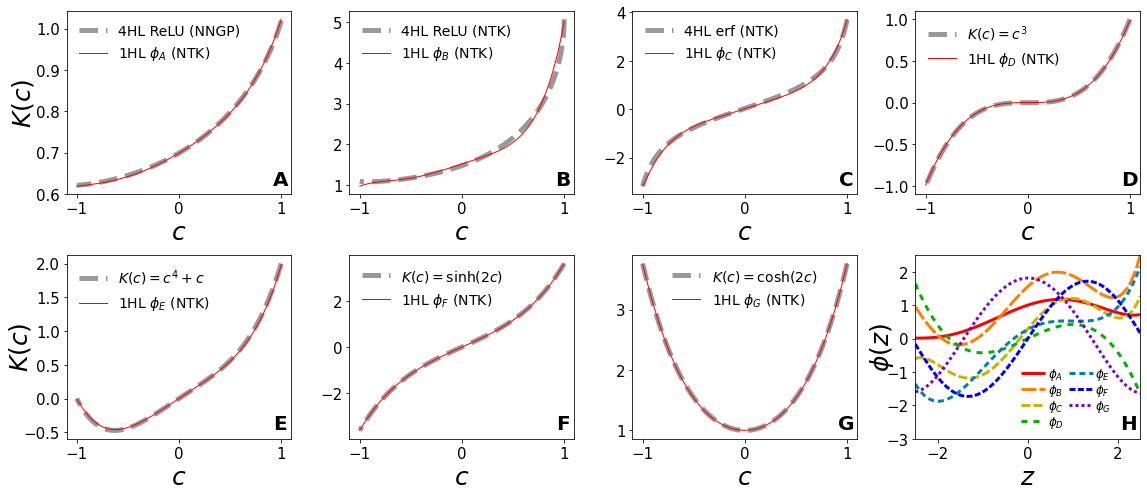

In [ ]:
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 7))
axs = axs.flatten()

for i, (name, letter) in enumerate(zip(target_names, 'ABCDEFGH')):
  ax = axs[i]

  ax.plot(cs, K_targets[name], color=(0,0,0,.4), linestyle='dashed', lw=5, label=name)

  if name in K_mimics:
    ax.plot(cs, K_mimics[name], color=(1,0,0), lw=1, label=f'1HL $\phi_{letter}$ (NTK)')

  ax.tick_params(axis='both', labelsize=15)
  ax.legend(frameon=False, fontsize=14)
  ax.set_xlabel('$c$', fontsize=25)
  ax.set_ylabel('$K(c)$' if i%ncols==0 else '', fontsize=25, labelpad=(0 if i==0 else -10))


  xs = np.linspace(-2.5, 2.5, 100)
  axs[7].plot(xs, phis[name](xs), lw=3, linestyle=(0,linestyles[i]), color=colors[i], label=f'$\phi_{letter}$')


axs[7].set_xlim((min(xs), max(xs)))
axs[7].set_ylim((-3,2.5))
axs[7].tick_params(axis='both', labelsize=15)
axs[7].legend(frameon=False, fontsize=12, ncol=2, labelspacing=0, columnspacing=.4, handletextpad=.2, loc=(.45, .02))
axs[7].set_xlabel('$z$', fontsize=25)
axs[7].set_ylabel('$\phi(z)$', fontsize=25, labelpad=-10)


for i in range(len(axs)):
  axs[i].text(.95, .05, 'ABCDEFGHI'[i], transform=axs[i].transAxes, size=20, weight='bold', ha='center')

fig.tight_layout()

plt.savefig('kernel_grid.pdf', transparent=True, dpi=300, bbox_inches='tight')